In [52]:
import os
import sys
import numpy as np
import tensorflow as tf
import input_data
import model

In [62]:
# you need to change the directories to yours.
train_dir = '../PetImages/train_convert/'
test_dir = '../PetImages/test/'
train_logs_dir = '../logs/train/'
val_logs_dir = '../logs/val'

N_CLASSES = 2
IMG_W = 208     # resize the image, if the input image is too large, training will be very slow.
IMG_H = 208
RATIO = 0.2     # take 20% of dataset as validation data
BATCH_SIZE = 64
CAPACITY = 2000
MAX_STEP = 1000 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 # with current parameters, it is suggested to use learning rate<0.0001

In [63]:
tf.reset_default_graph()

In [48]:
def training():

    train, train_label, val, val_label = input_data.get_files(train_dir, RATIO)
    train_batch, train_label_batch = input_data.get_batch(train,
                                                  train_label,
                                                  IMG_W,
                                                  IMG_H,
                                                  BATCH_SIZE,
                                                  CAPACITY)
    val_batch, val_label_batch = input_data.get_batch(val,
                                                  val_label,
                                                  IMG_W,
                                                  IMG_H,
                                                  BATCH_SIZE,
                                                  CAPACITY)

    #scale the float to -2.5 to 2.5
    #train_batch = (1/(2*2.25)) * train_batch + 0.5
#     CNN卷积操作
    logits = model.inference(train_batch, BATCH_SIZE, N_CLASSES)
#    损失函数
    loss = model.losses(logits, train_label_batch)
#     梯度下降
    train_op = model.trainning(loss, learning_rate)
#     准确率
    acc = model.evaluation(logits, train_label_batch)

    x = tf.placeholder(tf.float32, shape=[BATCH_SIZE, IMG_W, IMG_H, 3])
    y_ = tf.placeholder(tf.int16, shape=[BATCH_SIZE])


    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess= sess, coord=coord)
#         tensorboard查看
        summary_op = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(train_logs_dir, sess.graph)
        val_writer = tf.summary.FileWriter(val_logs_dir, sess.graph)

        try:
            for step in np.arange(MAX_STEP):
                if coord.should_stop():
                        break
                tra_images,tra_labels = sess.run([train_batch, train_label_batch])
                _, tra_loss, tra_acc = sess.run([train_op, loss, acc],
                                                feed_dict={x:tra_images, y_:tra_labels})
                if step % 50 == 0:
                    print('Step %d, train loss = %.2f, train accuracy = %.2f%%' %(step, tra_loss, tra_acc*100.0))
                    summary_str = sess.run(summary_op)
                    train_writer.add_summary(summary_str, step)

                if step % 200 == 0 or (step + 1) == MAX_STEP:
                    val_images, val_labels = sess.run([val_batch, val_label_batch])
                    val_loss, val_acc = sess.run([loss, acc],
                                                 feed_dict={x:val_images, y_:val_labels})
                    print('**  Step %d, val loss = %.2f, val accuracy = %.2f%%  **' %(step, val_loss, val_acc*100.0))
                    summary_str = sess.run(summary_op)
                    val_writer.add_summary(summary_str, step)

                if step % 2000 == 0 or (step + 1) == MAX_STEP:
                    checkpoint_path = os.path.join(train_logs_dir, 'model.ckpt')
                    saver.save(sess, checkpoint_path, global_step=step)

        except tf.errors.OutOfRangeError:
            print('Done training -- epoch limit reached')
        finally:
            coord.request_stop()
        try:
            coord.join(threads)
        except:
            error_type, error_value, trace_back = sys.exc_info()
            print(error_value)


In [49]:
#Test one image

def get_one_image(file_dir):
    """
    Randomly pick one image from test data
    Return: ndarray
    """
    from PIL import Image
    import matplotlib.pyplot as plt
    test =[]
    for file in os.listdir(file_dir):
        test.append(file_dir + file)
    print('There are %d test pictures\n' %(len(test)))

    n = len(test)
    ind = np.random.randint(0, n)
    print(ind)
    img_test = test[ind]

    image = Image.open(img_test)
    plt.imshow(image)
    image = image.resize([208, 208])
    image = np.array(image)
    return image

def test_one_image():
    """
    Test one image with the saved models and parameters
    """
    test_image = get_one_image(test_dir)

    with tf.Graph().as_default():
        BATCH_SIZE = 100
        N_CLASSES = 2

        image = tf.cast(test_image, tf.float32)
        image = tf.image.per_image_standardization(image)
        image = tf.reshape(image, [-1, 208, 208, 3])
        logit = model.inference(image, BATCH_SIZE, N_CLASSES)

        logit = tf.nn.softmax(logit)

        x = tf.placeholder(tf.float32, shape=[208, 208, 3])

        saver = tf.train.Saver()

        with tf.Session() as sess:

            print("Reading checkpoints...")
            ckpt = tf.train.get_checkpoint_state(train_logs_dir)
            if ckpt and ckpt.model_checkpoint_path:
                global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('Loading success, global_step is %s' % global_step)
            else:
                print('No checkpoint file found')

            prediction = sess.run(logit, feed_dict={x: test_image})
            max_index = np.argmax(prediction)
            if max_index==0:
                print('This is a cat with possibility %.6f' %prediction[:, 0])
            else:
                print('This is a dog with possibility %.6f' %prediction[:, 1])

In [50]:
# 命令行输入: tensorboard  --logdir=/tmp/mnist 查看结果
# 浏览器输入:127.0.0.1:6006

In [51]:
# if __name__ == '__main__':
training()
# test_one_image()

There are 11309 cats
There are 11238 dogs
conv1:  (64, 208, 208, 16)
norm1:  (64, 104, 104, 16)
conv2:  (64, 104, 104, 16)
pool2:  (64, 104, 104, 16)
local3:  (64, 128)
local4:  (64, 128)
Step 0, train loss = 0.69, train accuracy = 51.56%
**  Step 0, val loss = 0.69, val accuracy = 53.12%  **
Step 50, train loss = 0.68, train accuracy = 54.69%
Step 100, train loss = 0.69, train accuracy = 59.38%
Step 150, train loss = 0.69, train accuracy = 56.25%
Step 200, train loss = 0.65, train accuracy = 62.50%
**  Step 200, val loss = 0.65, val accuracy = 60.94%  **
Step 250, train loss = 0.70, train accuracy = 50.00%
Step 300, train loss = 0.65, train accuracy = 68.75%
Step 350, train loss = 0.63, train accuracy = 60.94%
Step 400, train loss = 0.63, train accuracy = 64.06%
**  Step 400, val loss = 0.67, val accuracy = 59.38%  **
Step 450, train loss = 0.64, train accuracy = 56.25%
Step 500, train loss = 0.67, train accuracy = 57.81%
Step 550, train loss = 0.59, train accuracy = 67.19%
Step 600, 

In [60]:
#Test one image

def get_one_image(file_dir):
    """
    Randomly pick one image from test data
    Return: ndarray
    """
    from PIL import Image
    import matplotlib.pyplot as plt
    test =[]
    for file in os.listdir(file_dir):
        test.append(file_dir + file)
    print('There are %d test pictures\n' %(len(test)))

    n = len(test)
    ind = np.random.randint(0, n)
    print(ind)
    img_test = test[ind]

    image = Image.open(img_test)
    plt.imshow(image)
    image = image.resize([208, 208])
    image = np.array(image)
    return image

def test_one_image():
    """
    Test one image with the saved models and parameters
    """
    test_image = get_one_image(test_dir)

    with tf.Graph().as_default():
        BATCH_SIZE = 100
        N_CLASSES = 2

        image = tf.cast(test_image, tf.float32)
        image = tf.image.per_image_standardization(image)
        image = tf.reshape(image, [-1, 208, 208, 3])
        logit = model.inference(image, BATCH_SIZE, N_CLASSES)

        logit = tf.nn.softmax(logit)

        x = tf.placeholder(tf.float32, shape=[208, 208, 3])

        saver = tf.train.Saver()

        with tf.Session() as sess:

            print("Reading checkpoints...")
            ckpt = tf.train.get_checkpoint_state(train_logs_dir)
            if ckpt and ckpt.model_checkpoint_path:
                global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('Loading success, global_step is %s' % global_step)
            else:
                print('No checkpoint file found')

            prediction = sess.run(logit, feed_dict={x: test_image})
            max_index = np.argmax(prediction)
            if max_index==0:
                print('This is a cat with possibility %.6f' %prediction[:, 0])
            else:
                print('This is a dog with possibility %.6f' %prediction[:, 1])


There are 2198 test pictures

1114
conv1:  (1, 208, 208, 16)
norm1:  (1, 104, 104, 16)
conv2:  (1, 104, 104, 16)
pool2:  (1, 104, 104, 16)


ValueError: Dimension size must be evenly divisible by 100 but is 173056 for 'local3/Reshape' (op: 'Reshape') with input shapes: [1,104,104,16], [2] and with input tensors computed as partial shapes: input[1] = [100,?].

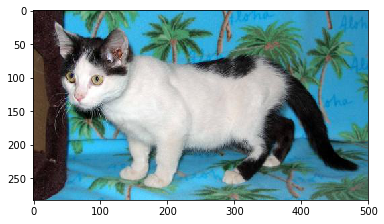

In [61]:
test_one_image()